In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from scipy.stats import ks_2samp
from scipy import interp
from modshogun import *

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# SQL database config
sqluser = 'o4nguyen'
dbname = 'MIMIC3'
schema_name = 'mimiciii'
hostname = 'hdsldb.uwaterloo.ca'
port = 5432
pwd = getpass.getpass()

········


In [3]:
# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser, host=hostname, port=5432, password=pwd)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

In [5]:
query = \
"""
SELECT COUNT(DISTINCT subject_id) 
AS "Hypertension" 
FROM diagnoses_icd 
WHERE icd9_code 
-- 401% will search for all icd9 codes relating to hypertension
LIKE '401%';
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,Hypertension
0,18031


In [6]:
query = \
"""
SELECT COUNT(DISTINCT icd9_code)
AS "icd9" 
FROM diagnoses_icd 
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,icd9
0,6984


In [7]:
query = \
"""
WITH diatbl AS 
	(
	SELECT DISTINCT ON (dia.subject_id) dia.subject_id, ad.admittime
	FROM diagnoses_icd dia
	INNER JOIN admissions ad
	ON dia.subject_id = ad.subject_id
	WHERE dia.icd9_code 
	-- 401% relates to hypertension
	LIKE '401%'
	),
agetbl AS 
	(
	SELECT dt.subject_id,
	(extract(DAY FROM dt.admittime - p.dob)
	+ extract(HOUR FROM dt.admittime - p.dob)/24
	+ extract(MINUTE FROM dt.admittime - p.dob)/24/60)/365.25
	AS age
	FROM diatbl dt
	INNER JOIN patients p
	ON dt.subject_id = p.subject_id
	)
SELECT
        COUNT(*) AS TOTAL,
        COUNT(CASE WHEN age >= 0 AND age < 16 THEN  '0 - 15' END) AS "0-15",
        COUNT(CASE WHEN age >= 16 AND age < 21 THEN '16 - 20' END) AS "16-20",
        COUNT(CASE WHEN age >= 21 AND age < 26 THEN '21 - 25' END) AS "21-25",
        COUNT(CASE WHEN age >= 26 AND age < 31 THEN '26 - 30' END) AS "26-30",
        COUNT(CASE WHEN age >= 31 AND age < 36 THEN '31 - 35' END) AS "31-35",
        COUNT(CASE WHEN age >= 36 AND age < 41 THEN '36 - 40' END) AS "36-40",
        COUNT(CASE WHEN age >= 41 AND age < 46 THEN '41 - 45' END) AS "41-45",
        COUNT(CASE WHEN age >= 46 AND age < 51 THEN '46 - 50' END) AS "46-50",
        COUNT(CASE WHEN age >= 51 AND age < 56 THEN '51 - 55' END) AS "51-55",
        COUNT(CASE WHEN age >= 56 AND age < 61 THEN '56 - 60' END) AS "56-60",
        COUNT(CASE WHEN age >= 61 AND age < 66 THEN '61 - 65' END) AS "61-65",
        COUNT(CASE WHEN age >= 66 AND age < 71 THEN '66 - 70' END) AS "66-70",
        COUNT(CASE WHEN age >= 71 AND age < 76 THEN '71 - 75' END) AS "71-75",
        COUNT(CASE WHEN age >= 76 AND age < 81 THEN '76 - 80' END) AS "76-80",
        COUNT(CASE WHEN age >= 81 AND age < 86 THEN '81 - 85' END) AS "81-85",
        COUNT(CASE WHEN age >= 86 AND age < 91 THEN '86 - 90' END) AS "86-91",
        COUNT(CASE WHEN age >= 91 THEN 'Over 91' END) AS ">91"
FROM agetbl;
"""

query_output = pd.read_sql_query(query,con) #.dropna().reset_index(drop=True)
query_output.head()

,total,0-15,16-20,21-25,26-30,31-35,36-40,41-45,46-50,51-55,56-60,61-65,66-70,71-75,76-80,81-85,86-91,>91
0,18031,13,14,55,62,144,293,552,915,1385,1863,2144,2195,2197,2375,1938,816,1070


(array([    0.,   500.,  1000.,  1500.,  2000.,  2500.]),
 <a list of 6 Text yticklabel objects>)

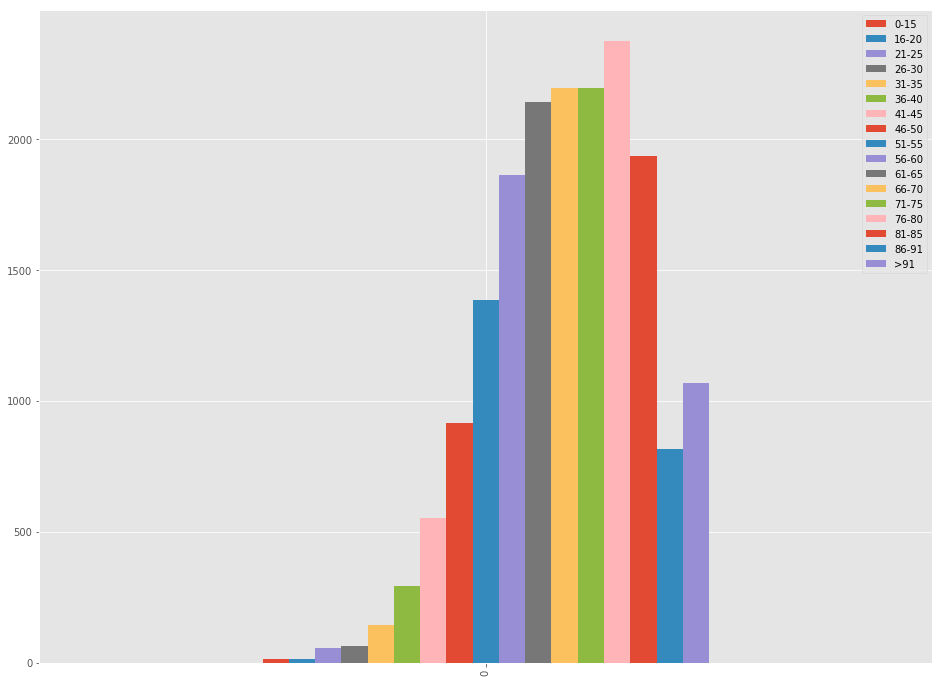

In [19]:
query_output.loc[:, '0-15':].plot.bar(figsize=(16, 12))
plt.xticks()
plt.yticks()